<a href="https://colab.research.google.com/github/screemix/raai_neuro/blob/main/Logit_sin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install brian2

In [2]:
import brian2 as b2
import numpy as np
import matplotlib.pyplot as plt

import warnings
from math import sin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support
import random 

warnings.filterwarnings("ignore", category=DeprecationWarning)

In [36]:
def plot_v(v_mon, v_threshold=None, limit=None):
    #plt.subplot(211)
    if limit:
      plt.plot(v_mon.t[:250]/b2.ms, v_mon.v[0][:250]/b2.mvolt, label='Membrane voltage')
    else:
      plt.plot(v_mon.t/b2.ms, v_mon.v[0]/b2.mvolt, label='Membrane voltage')
    plt.xlabel('Time (ms)')
    plt.ylabel('v (mV)')
    if v_threshold:
        plt.axhline(v_threshold/b2.mvolt, ls='--', c='C2', label='threshold') #plot threshold
        
def plot_spikes(s_mon):
    for t in s_mon.t:
        b2.axvline(t/b2.ms, ls='--', c='C1', lw=3)

def plot_I(mon, current):
    plt.xlabel('Time (ms)')
    plt.ylabel('I (nA)')
    plt.plot(mon.t / b2.ms, current(mon.t)/b2.namp, "r", lw=2,
            label='Input current') 
    
def plot_v_spikes(v_mon, s_mon, t_bounds=None):
    b2.figure(figsize=(12,4))
    b2.subplot(121)
    b2.plot(v_mon.t/b2.ms, v_mon.v[0], label='left')
    b2.plot(v_mon.t/b2.ms, v_mon.v[1], label='right')
    if t_bounds:
        b2.xlim(t_bounds)
    b2.xlabel('Time (ms)')
    b2.ylabel('v')
    b2.legend();
    b2.subplot(122)
    b2.plot(s_mon.t/b2.ms,s_mon.i, '.k')
    if t_bounds:
        b2.xlim(t_bounds)
    b2.xlabel('Time (ms)')
    b2.ylabel('Neuron num')     

In [4]:
def generate_time_array(time, spikes):
  time_array = []
  for t in time:
    time_array.append(t in spikes)
  return time_array

def generate_dataset(I, time, window=15, shift=1):
  n = len(I)
  x = []
  y = []
  for i in range(0, n-window, shift):
    x.append(I[i:i+window])
    if True in time[i:i+window]:
      y.append(1)
    else:
      y.append(0)
  
  return {"x": np.stack(x), "y": np.array(y)}

def generate_balanced_dataset(I, time, window=15, shift=1):
  n = len(I)
  x_positive = []
  x_negative = []
  y_positive = []
  y_negative = []

  for i in range(0, n-window, shift):  
    if True in time[i:i+window]:
      x_positive.append(I[i:i+window])
    else:
      x_negative.append(I[i:i+window])

  x_negative_subsample = random.sample(x_negative, len(x_positive))
  x = x_negative_subsample + x_positive
  y = [0 for i in x_negative_subsample] + [1 for i in x_positive]
  
  return {"x": np.stack(x), "y": np.array(y)}

def generate_scatters(logits, window, y=-35):
  points = {"x": [], "y": []}

  for i, spike in enumerate(logits):
    if spike == 0:
      continue

    low = i
    high = i + window
    x = (low + high) / 2
    points["x"].append(x)
    points["y"].append(y)

  return points

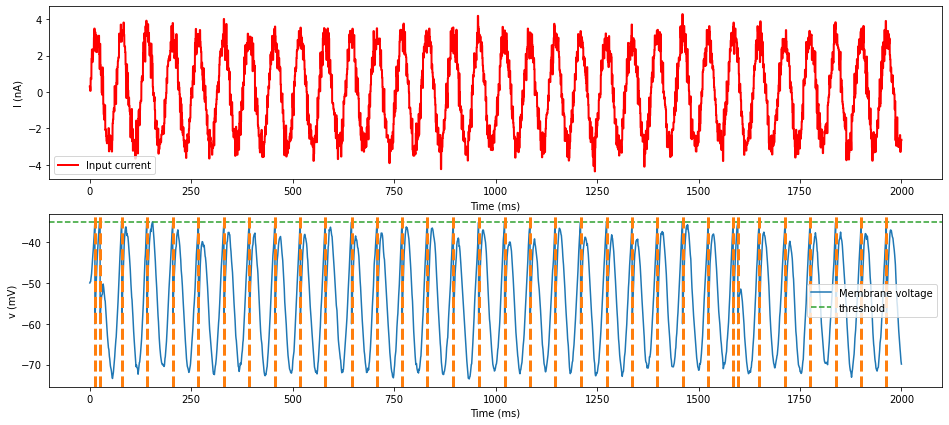

In [24]:
b2.start_scope()

R = 10. * b2.Mohm # membrane resistance 
tau = 10*b2.ms # membrane time scale
v_rest = -50 * b2.mvolt # rest potential 
v0 = v_rest # initial potential
v_th = -35 * b2.mvolt # threshold
v_reset = -60 * b2.mvolt # reset potential
T = 2000 * b2.ms # simulation time

I_arr = [3*sin(1/10 * c) + np.random.normal(0,0.5,1)[0] for c in range(0, 2000)]
I = b2.TimedArray(I_arr * b2.namp, dt=1*b2.ms)

eqs ='''
dv/dt=(v_rest-v)/tau + R*I(t)/tau : volt
'''
G = b2.NeuronGroup(1,eqs,
                   threshold='v>v_th', 
                   reset='v = v_reset', 
                   method='linear')
G.v = v0
M = b2.StateMonitor(G, 'v', record=True)
spikemon = b2.SpikeMonitor(G)
b2.run(T)

_,(ax_I, ax_V) = plt.subplots(2,1, figsize=(16,7))
plt.subplot(ax_I)
plot_I(M, I)
plt.legend()
plt.subplot(ax_V)
plot_v(M, v_th)
plt.legend()
plot_spikes(spikemon)

In [25]:
ts = generate_time_array(M.t, spikemon.t)

In [26]:
for window in [10, 15, 20, 25, 30, 40, 50]:
  dataset = generate_balanced_dataset(I_arr, ts, window=window)
  X_train, X_test, y_train, y_test = train_test_split(dataset["x"], dataset["y"], test_size=0.33, random_state=42, shuffle=True)
  clf = LogisticRegression(random_state=0).fit(X_train, y_train)
  logits = clf.predict(X_test)
  print("Accuracy with wnidow {} for train".format(window), accuracy_score(clf.predict(X_train), y_train))
  print("F-charachteristics with wnidow {} for train".format(window), precision_recall_fscore_support(clf.predict(X_train), y_train))
  print()
  print("Accuracy with wnidow {} for test".format(window), accuracy_score(logits, y_test))
  print("F-charachteristics with wnidow {} for test".format(window), precision_recall_fscore_support(logits, y_test))
  print()
  print("---------------------------------------------------------------------")
  print()

Accuracy with wnidow 10 for train 0.6226415094339622
F-charachteristics with wnidow 10 for train (array([0.61538462, 0.62962963]), array([0.61538462, 0.62962963]), array([0.61538462, 0.62962963]), array([26, 27]))

Accuracy with wnidow 10 for test 0.48148148148148145
F-charachteristics with wnidow 10 for test (array([0.5       , 0.46153846]), array([0.5       , 0.46153846]), array([0.5       , 0.46153846]), array([14, 13]))

---------------------------------------------------------------------

Accuracy with wnidow 15 for train 0.6
F-charachteristics with wnidow 15 for train (array([0.5       , 0.69047619]), array([0.59375   , 0.60416667]), array([0.54285714, 0.64444444]), array([32, 48]))

Accuracy with wnidow 15 for test 0.425
F-charachteristics with wnidow 15 for test (array([0.45454545, 0.38888889]), array([0.47619048, 0.36842105]), array([0.46511628, 0.37837838]), array([21, 19]))

---------------------------------------------------------------------

Accuracy with wnidow 20 for t

In [47]:
real_dataset = generate_dataset(I_arr, ts, window=15)

In [48]:
dataset = generate_balanced_dataset(I_arr, ts, window=15)
X_train, X_test, y_train, y_test = train_test_split(dataset["x"], dataset["y"], test_size=0.33, random_state=42, shuffle=True)
clf = LogisticRegression(random_state=0).fit(X_train, y_train)

In [49]:
real_logits = clf.predict(real_dataset["x"])

In [50]:
points = generate_scatters(real_logits, window=15)

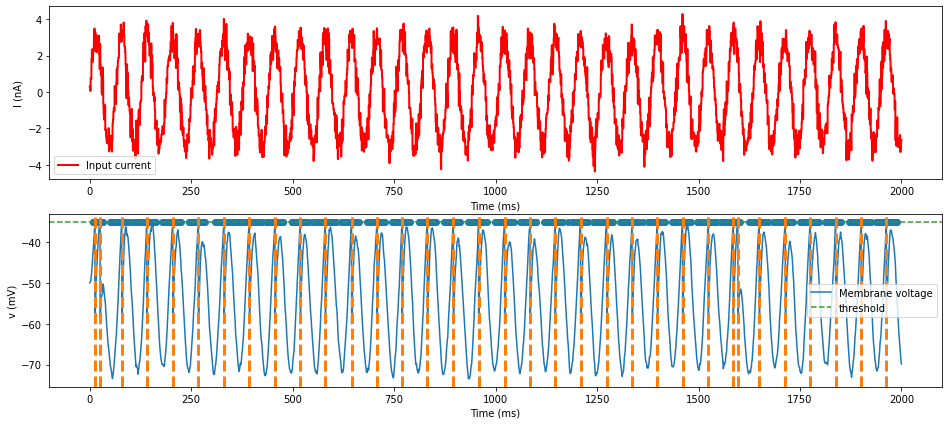

In [51]:
_,(ax_I, ax_V) = plt.subplots(2, 1, figsize=(16,7))
plt.subplot(ax_I)
plot_I(M, I)
plt.legend()
plt.subplot(ax_V)
plot_v(M, v_th)
plt.legend()
plot_spikes(spikemon)
plt.scatter(points["x"], points["y"])

In [33]:
real_logits

array([1, 0, 1, ..., 1, 0, 0])